In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
dyn_adata = dyn.sample_data.zebrafish()
print("original data shape:", dyn_adata.shape)


|-----> Downloading data to ./data/zebrafish.h5ad


original data shape: (4181, 16940)


## Convert Data for R Seurat inputs

In [2]:
import scipy
import scipy.io
dyn.preprocessing.convert_layers2csr(dyn_adata)
dyn.preprocessing.unique_var_obs_adata(dyn_adata)
scipy.io.mmwrite("counts.mtx", dyn_adata.X)
scipy.io.mmwrite("spliced.mtx", dyn_adata.layers["spliced"])
scipy.io.mmwrite("unspliced.mtx", dyn_adata.layers["unspliced"])


In [3]:
pd.Series(dyn_adata.obs_names).to_csv("./data/cell_names.csv")
pd.Series(dyn_adata.var_names).to_csv("./data/var_names.csv")


In [4]:
seurat_X_pca = pd.read_csv("./R-seurat-test/X_pca.csv")


In [5]:
seurat_X_pca[:2]


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
TGCCAAATCACCACCT-1-0,-5.857340,2.867679,0.169394,0.86043,0.185787,0.855904,-0.13344,3.436429,-0.656718,-1.001899,...,0.439428,-0.271046,0.233556,0.842144,0.126444,-0.300330,-0.259993,0.201506,0.691337,-0.898238
AAATGCCAGGAGCGTT-1-0,-5.925883,5.597495,-0.900045,-10.14316,0.501072,-4.512660,0.89789,2.204267,-1.688371,-1.772579,...,-0.089032,-1.277523,-0.383998,0.783514,-0.988206,3.932976,0.766193,-3.019138,-1.428712,0.049915


<AxesSubplot:ylabel='Count'>

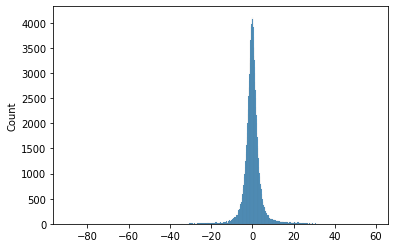

In [6]:
X_pca_arr = seurat_X_pca.to_numpy().flatten()
sns.histplot(X_pca_arr)


In [7]:
print(seurat_X_pca.shape)
print(dyn_adata.shape)


(4181, 50)
(4181, 16940)


In [8]:
dyn_adata.obs_names[:10]


Index(['TGCCAAATCACCACCT-1-0', 'AAATGCCAGGAGCGTT-1-0', 'CAGCGACAGAGAACAG-1-0',
       'GGGACCTGTGACCAAG-1-0', 'TCCCGATAGTGTGGCA-1-0', 'CAGAGAGAGGCGATAC-1-0',
       'AACTGGTAGTGGAGAA-1-0', 'ATTGGACGTCTAGCGC-1-0', 'TGGGCGTCACCAGGTC-1-0',
       'TTGGCAAAGGGCTTCC-1-0'],
      dtype='object', name='index')

In [9]:
seurat_adata = dyn.sample_data.zebrafish()
dyn.preprocessing.unique_var_obs_adata(seurat_adata)
print(seurat_X_pca.shape)
print(seurat_adata.shape)
print(set(seurat_X_pca.index) - set(seurat_adata.obs_names))
print(set(seurat_adata.obs_names) - set(seurat_X_pca.index))


|-----> Downloading data to ./data/zebrafish.h5ad


(4181, 50)
(4181, 16940)
set()
set()


### reorder seurat_X_pca index in adata obs_name order and set to X_pca

In [10]:

seurat_adata.obsm["X_pca"] = seurat_X_pca.loc[seurat_adata.obs_names, :].to_numpy()


In [16]:
dyn_adata_preprocessor = dyn.read_h5ad(
    "./data/zebrafish_sctransform_preprocessor.h5ad")


In [18]:
dyn_adata_preprocessor


AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'pass_basic_filter', 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct', 'use_for_pca'
    uns: 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pp'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced'

## sample preprocessor code
```
from SCTransform import SCTransform
dyn_adata_preprocessor = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(dyn_adata_preprocessor)
preprocessor.normalize_by_cells = None
# preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
# preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
preprocessor.filter_cells_by_outliers(dyn_adata_preprocessor, keep_filtered=False)
preprocessor.filter_genes_by_outliers(dyn_adata_preprocessor, inplace=True)
SCTransform(dyn_adata_preprocessor, inplace=True)
preprocessor.use_log1p = False
preprocessor.pca(dyn_adata, n_pca_components=50)
```

In [22]:
dyn_adata_preprocessor.obsm[key].shape
seurat_adata.obsm[key].shape


(4181, 50)

Text(0.5, 1.0, 'X_pca')

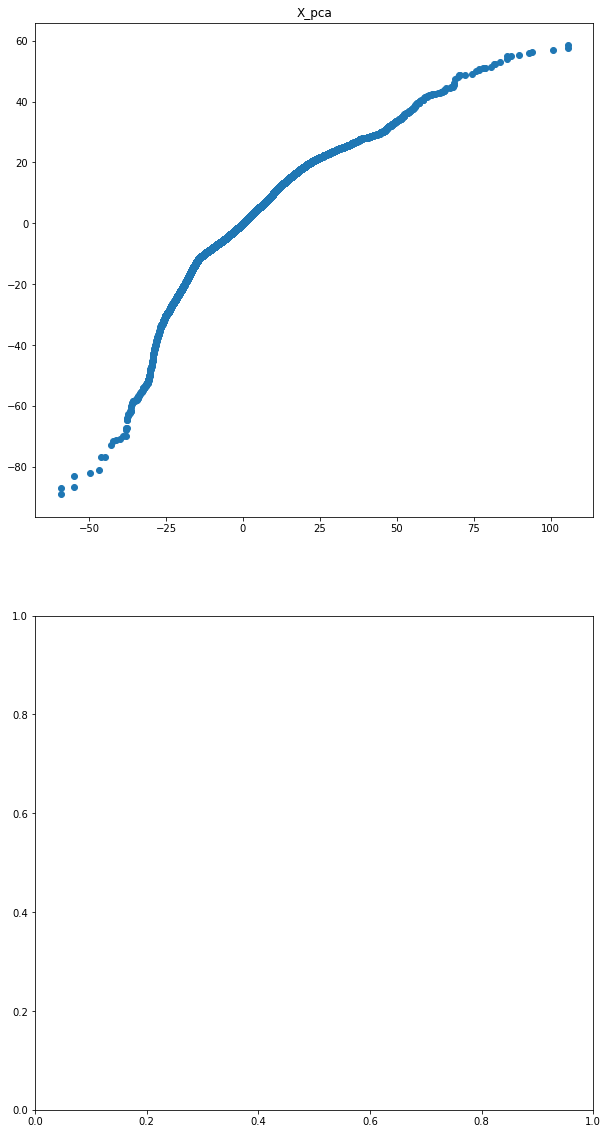

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 20))
key = "X_pca"
use_for_pca = list(
    set(dyn_adata_preprocessor.var_names[dyn_adata_preprocessor.var["use_for_pca"]]))
axes[0].scatter(np.sort(dyn_adata_preprocessor.obsm[key].flatten()),
                np.sort(seurat_adata[dyn_adata_preprocessor.obs_names, :].obsm[key].flatten()))  # , title="X_pca comparison")
axes[0].set_title(key)


In [ ]:

dyn.tl.reduceDimension(seurat_adata, basis="pca")
dyn.pl.umap(seurat_adata, color="Cell_type", figsize=(10, 10))
